In [1]:
#upgraded to tensorflow 2.6 for installation of segmentation models
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import random
import os
import datetime as dt
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
import PIL
from PIL import ImageOps
from skimage.io import imshow,imread, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras import utils


%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import sys

try:
     from livelossplot import PlotLossesKeras
except:
    !pip install livelossplot
    from livelossplot import PlotLossesKeras
try:
    from tqdm import tqdm
except:
    !pip install tqdm
import glob
import matplotlib.patches as patches

# 0 Atrium,1 Background, 2 Ventricle 
def remove_overlap(ImageBatch,t=0.1):
    out=np.zeros([ImageBatch.shape[0],512,512,3])
    for i in range(ImageBatch.shape[0]):
        a=ImageBatch[i,:,:,:]
        b0=np.where((a[:,:,0]>t) & (a[:,:,1]<t) & (a[:,:,2]<t), 1, 0)
        b1=np.where((a[:,:,0]<t) & (a[:,:,1]>t) & (a[:,:,2]<t), 1, 0)
        b2=np.where((a[:,:,0]<t) & (a[:,:,1]<t) & (a[:,:,2]>t), 1, 0)
        out[i,:,:,:]=np.stack([b0,b1,b2],axis=2).astype("float32")
    return out

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
keras.backend.set_image_data_format('channels_last')

In [3]:
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(tf.config.experimental.get_memory_usage('GPU:0'))
    print(tf.config.experimental.get_memory_info('GPU:0'))

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
0
{'current': 0, 'peak': 0}


In [4]:
def multi_dice_coef(y_true, y_pred, smooth=1):
    
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -multi_dice_coef(y_true, y_pred)

#Store images as tif stack in imagej
#Performing minmax normalization
image_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/Export_Frame1.tif")

for i in range(image_stack.shape[0]):
    im=image_stack[i,:,:]
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8')
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0
mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/Export_Frame1_masks.tif")

for j in range(mask_stack.shape[0]):
    mask=mask_stack[j,:,:]
    mask_new=np.zeros([512,512,3],dtype="uint8")
    mask_new[:,:,1][mask[:,:,1] == 255]=1 #Background
    mask_new[:,:,2][mask[:,:,2] == 0]=1   #Ventricle
    mask_new[:,:,0][mask[:,:,0] == 0]=1   #Atrium
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_"+str(j)+".tif",mask_new)
    
#Second import
image_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/1D_All_F11.tif")

for i in range(image_stack.shape[0]):
    im=image_stack[i,:,:]
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8')
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_All_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0
mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1D_All_F11_mask.tif")

for j in range(mask_stack.shape[0]):
    mask=mask_stack[j,:,:]
    mask_new=np.zeros([512,512,3],dtype="uint8")
    mask_new[:,:,1][mask[:,:,1] == 255]=1 #Background
    mask_new[:,:,2][mask[:,:,2] == 0]=1   #Ventricle
    mask_new[:,:,0][mask[:,:,0] == 0]=1   #Atrium
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_All_"+str(j)+".tif",mask_new)
#Third import
image_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/1D_first6_F002_G009.tif")

for i in range(image_stack.shape[0]):
    im=image_stack[i,:,:]
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8')
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_f002_g008_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0
mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1D_first6_F002_G009_annotated.tif")

for j in range(mask_stack.shape[0]):
    mask=mask_stack[j,:,:]
    mask_new=np.zeros([512,512,3],dtype="uint8")
    mask_new[:,:,1][mask[:,:,1] == 255]=1 #Background
    mask_new[:,:,2][mask[:,:,2] == 0]=1   #Ventricle
    mask_new[:,:,0][mask[:,:,0] == 0]=1   #Atrium
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_f002_g008_"+str(j)+".tif",mask_new)
    
    image_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/1Drep_all_F2.tif")
#4th import
for i in range(image_stack.shape[0]):
    im=image_stack[i,:,:]
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8')
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_1Drep_all_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0
    mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1Drep_all_F2_masks.tif")

for j in range(mask_stack.shape[0]):
    mask=mask_stack[j,:,:]
    mask_new=np.zeros([512,512,3],dtype="uint8")
    mask_new[:,:,1][mask[:,:,1] == 255]=1 #Background
    mask_new[:,:,2][mask[:,:,2] == 0]=1   #Ventricle
    mask_new[:,:,0][mask[:,:,0] == 0]=1   #Atrium
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_1Drep_all_"+str(j)+".tif",mask_new)

#5th import

image_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/Stack_Frame1_Low.tif")
for i in range(image_stack.shape[0]): 
    im=image_stack[i,:,:] 
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8') 
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Stack_Frame1_Low_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0 mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1Drep_all_F2_masks.tif")

mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/Stack_Frame1_Low_masks.tif")

for j in range(mask_stack.shape[0]): 
    mask=mask_stack[j,:,:] 
    mask_new=np.zeros([512,512,3],dtype="uint8") 
    mask_new[:,:,1][mask[:,:,1] == 255]=1 
    #Background 
    mask_new[:,:,2][mask[:,:,2] == 0]=1 
    #Ventricle 
    mask_new[:,:,0][mask[:,:,0] == 0]=1 
    #Atrium 
    imsave("D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Stack_Frame1_Low_"+str(j)+".tif",mask_new)

In [5]:
#os.mkdir("D:/Alex/DeepSeg_Heart/Data/Training/Cat_Annotations/")

In [6]:
from livelossplot import PlotLossesKeras

In [7]:
input_dir = "D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/"
target_dir = "D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/"
img_size = (512, 512)
num_classes = 3
batch_size = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".tif")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 348
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_0.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_0.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_1.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_1.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_10.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_10.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_11.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_11.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_12.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_12.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_13.tif | D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_13.tif
D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_14.tif | D:/Alex/De

In [8]:
img_arr=np.zeros([len(input_img_paths),512,512,1])
mask_arr=np.zeros([len(input_img_paths),512,512,3])

for i,(img_path,mask_path) in enumerate(zip(input_img_paths,target_img_paths)):
    print(i,img_path,mask_path)
    img = imread(img_path)
    mask = imread(mask_path)
    
    img_arr[i,:,:,0]=img
    mask_arr[i,:,:,:]=mask.astype("float32")

    

0 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_0.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_0.tif
1 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_1.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_1.tif
2 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_10.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_10.tif
3 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_11.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_11.tif
4 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_12.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_12.tif
5 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_13.tif D:/Alex/DeepSeg_Heart/Data/Training/Annotations/Annotations/Heart_Image_13.tif
6 D:/Alex/DeepSeg_Heart/Data/Training/Images/Images/Heart_Image_14.tif D:/Alex/DeepSeg_Heart/Data/Traini

In [9]:
#sm --> resnet18 needs image as uint8 0-255
#unet from deeplearning course --> needs image as float32 0.0-1.0
image_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        fill_mode='reflect',
        dtype="uint8",
        validation_split=0.25
        )
mask_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        fill_mode='reflect',
        dtype="float32",
        validation_split=0.25
        )
seed=1
image_datagen.fit(img_arr, augment=True, seed=seed)
mask_datagen.fit(mask_arr, augment=True, seed=seed)

train_image_generator = image_datagen.flow_from_directory(
input_dir.rsplit("/",2)[0],
batch_size = batch_size,class_mode=None, target_size=img_size,seed=seed,color_mode="grayscale",subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
target_dir.rsplit("/",2)[0],
batch_size = batch_size,class_mode=None, target_size=img_size,seed=seed,color_mode="rgb",
subset='training')

#save_format="tif",save_to_dir="D:/Alex/DeepSeg_Heart/Data/Training/Augmentations/",save_prefix="Aug_Mask_",...save_to_dir="D:/Alex/DeepSeg_Heart/Data/Training/Augmentations/",save_prefix="Aug_Img_",save_format="tif"

validation_image_generator = image_datagen.flow_from_directory(
input_dir.rsplit("/",2)[0],
batch_size = batch_size,class_mode=None, target_size=img_size,seed=seed,color_mode="grayscale",subset='validation')


#,save_to_dir="D:/Alex/DeepSeg_Heart/Data/Training/Augmentations/",save_prefix="Aug_Img_",save_format="tif",... ,save_format="tif",save_to_dir="D:/Alex/DeepSeg_Heart/Data/Training/Augmentations/",save_prefix="Aug_Mask_"
validation_mask_generator = mask_datagen.flow_from_directory(
target_dir.rsplit("/",2)[0],
batch_size = batch_size,class_mode=None, target_size=img_size,seed=seed,color_mode="rgb",subset='validation')


train_generator = zip(((im[:,:,:,0]).astype("uint8") for im in train_image_generator), (remove_overlap(m) for m in train_mask_generator))
validation_generator = zip(((im[:,:,:,0]).astype("uint8") for im in validation_image_generator), (remove_overlap(m) for m in validation_mask_generator))

Found 261 images belonging to 1 classes.
Found 261 images belonging to 1 classes.
Found 87 images belonging to 1 classes.
Found 87 images belonging to 1 classes.


In [10]:
# working with sm.model resnet18 and image as integer
cls_weights = np.array([1,0.5,2])
weights = str(cls_weights)
jacc_loss = sm.losses.JaccardLoss(class_weights=cls_weights, class_indexes=None, per_image=False, smooth=1e-05)
dice_loss  = sm.losses.DiceLoss(class_weights=cls_weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

iou_score = sm.metrics.IOUScore()
simple_diceloss = dice_loss * -1 

precision = sm.metrics.Precision()

purpose="HeartSeg"
backbone='resnet18'
pat=50
lr=0.001
activation= 'softmax'
loss_func= (jacc_loss,'weightedJaccLoss')
training_size=len(input_img_paths)

# batch_size= batch_size defined with input
epochs = 250
st_per_ep=100
val_steps=25
model_name= "{}_{}_bb_{}__trainSz_{}__lossfun_{}__lr_{}__act_{}__batchsz_{}__pat-{}__epo-{}__weights-{}".format(str(dt.date.today()).replace("-",""),purpose,backbone, training_size,loss_func[1], lr,activation,batch_size,pat,epochs,weights)

if not os.path.exists("./Logs"):
    os.mkdir("./Logs")

csv_logger = CSVLogger('./Logs/{}.log'.format(model_name), separator=',', append=False)
metrics_list = [iou_score, simple_diceloss, dice_loss, 'accuracy']
print(model_name)

model = sm.Unet(backbone, input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation=activation)
model.compile(optimizer=Adam(learning_rate=lr), loss=loss_func[0],metrics=metrics_list)

20220725_HeartSeg_bb_resnet18__trainSz_348__lossfun_weightedJaccLoss__lr_0.001__act_softmax__batchsz_4__pat-50__epo-250__weights-[1.  0.5 2. ]


# val_loss = 0.15775 -->model = sm.Unet('resnet18', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=10 learning_rate=0.001
# val_loss = 0.13681 -->model = sm.Unet('resnet34', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=10 learning_rate=0.001
# val_loss = 0.11450 -->model = sm.Unet('resnet50', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.001
# val_loss = 0.12879 -->model = sm.Unet('resnet18', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.001
# out of memory sm.Unet('resnet101', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.001
# val_loss = 0.12342 -->model = sm.Unet('resnet50', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.0001
# val_loss = 0.12194 -->model = sm.Unet('resnet50', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.0001 batch_size =8
# val_loss = 0.110   -->model = sm.Unet('resnet50', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.001 weighted jacc loss
# val_loss = -0.010  -->model = sm.Unet('resnet50', input_shape=(512, 512, 1),classes=3, encoder_weights=None,activation="softmax") patience=50 learning_rate=0.001 weighted jacc loss double data training


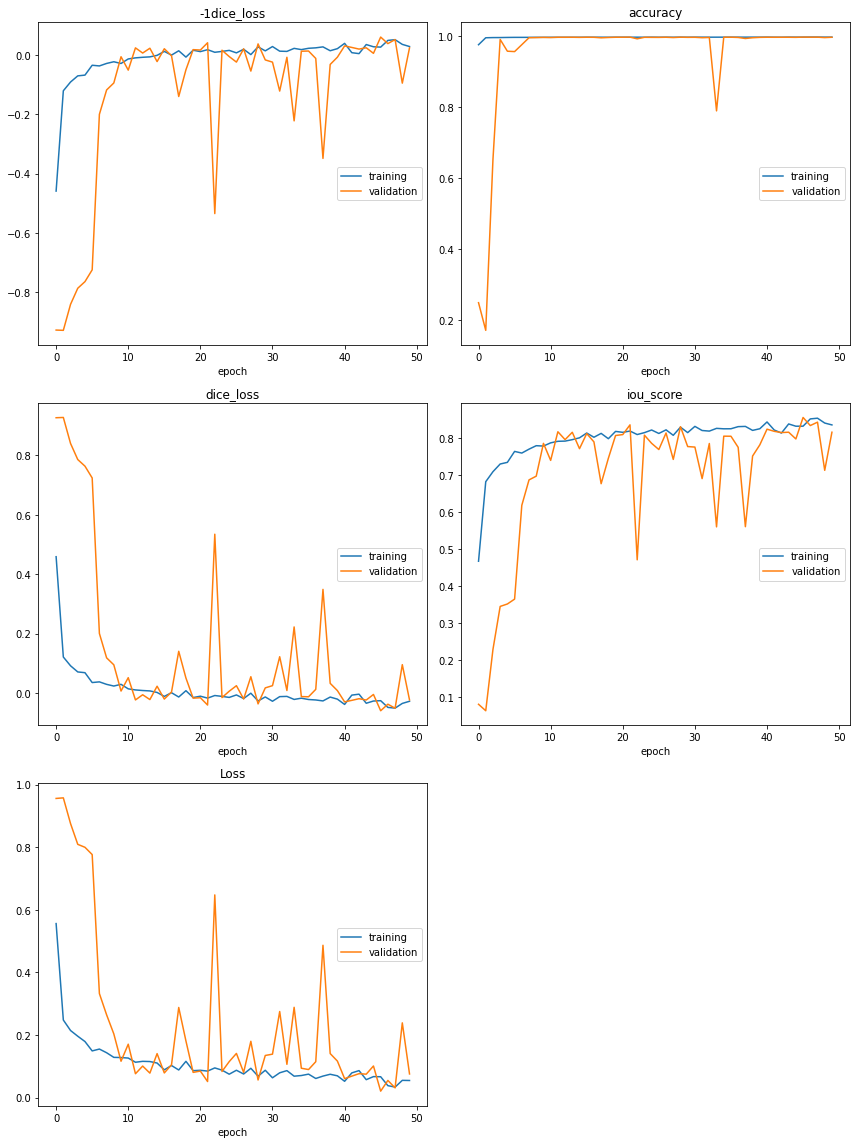

-1dice_loss
	training         	 (min:   -0.459, max:    0.051, cur:    0.028)
	validation       	 (min:   -0.928, max:    0.060, cur:    0.023)
accuracy
	training         	 (min:    0.977, max:    0.998, cur:    0.998)
	validation       	 (min:    0.170, max:    0.998, cur:    0.998)
dice_loss
	training         	 (min:   -0.051, max:    0.459, cur:   -0.028)
	validation       	 (min:   -0.060, max:    0.928, cur:   -0.023)
iou_score
	training         	 (min:    0.467, max:    0.854, cur:    0.836)
	validation       	 (min:    0.063, max:    0.856, cur:    0.816)
Loss
	training         	 (min:    0.033, max:    0.556, cur:    0.054)
	validation       	 (min:    0.020, max:    0.958, cur:    0.075)
Epoch 51/250
 17/100 [====>.........................] - ETA: 23s - loss: 0.0603 - iou_score: 0.8211 - -1dice_loss: 0.0208 - dice_loss: -0.0208 - accuracy: 0.9982

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aernst\AppData\Local\Temp/ipykernel_10816/2287481353.py", line 12, in <module>
    model.fit(train_generator,validation_data=validation_generator,batch_size=batch_size,validation_steps=val_steps,steps_per_epoch=st_per_ep ,epochs=epochs, callbacks=callbacks_list)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aernst\AppData\Local\Temp/ipykernel_10816/2287481353.py", line 12, in <module>
    model.fit(train_generator,validation_data=validation_generator,batch_size=batch_size,validation_steps=val_steps,steps_per_epoch=st_per_ep ,epochs=epochs, callbacks=callbacks_list)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\aernst\Miniconda3\envs\TF25\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not

In [ ]:

## early stoping and checkpoint also init the plotloss function
early_stop = EarlyStopping(monitor='val_loss', patience=pat, mode='min')
## name the model
filepath="../Model/"+model_name+".h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
plotlosses = PlotLossesKeras()
callbacks_list = [checkpoint, early_stop,plotlosses,csv_logger]


# Train the model, doing validation at the end of each epoch.

model.fit(train_generator,validation_data=validation_generator,batch_size=batch_size,validation_steps=val_steps,steps_per_epoch=st_per_ep ,epochs=epochs, callbacks=callbacks_list)

In [46]:
#model.load_weights("../Model/AIM_BestWeights_heart_"+model_name+".h5")
#model=keras.models.load_model("../Model/AIM_BestWeights_heart_bb_resnet18__trainSz_348__lossfun_weightedJaccLoss__lr_0.001__act_softmax__batchsz_4__pat-50__epo-250.h5",custom_objects={"jaccard_loss" : jacc_loss,"dice_loss":dice_loss})

model=keras.models.load_model(filepath,custom_objects={"jaccard_loss" : jacc_loss,"dice_loss":dice_loss}
#val_preds = model.predict(img_arr)

In [ ]:
np.unique(val_preds[0,:,:,2])

In [ ]:
plt.figure(figsize=(20,20))

n=120
plt.subplot(131)
imshow(val_preds[n,:,:,2]>0.6)
plt.subplot(132)
imshow(img_arr[n,:,:,0])
plt.subplot(133)
imshow(mask_arr[n,:,:,2])
plt.show()

In [13]:
# Process test annotations
image_stack = imread("D:/Alex/DeepSeg_Heart/Data/Stack/Images/1E_Frame1_Stack.tif")
for i in range(image_stack.shape[0]): 
    im = image_stack[i,:,:] 
    new_arr = ((im - im.min()) * (1/(im.max() - im.min()) * 255)).astype('uint8') 
    imsave("D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_"+str(i)+".tif",new_arr)

#Masks as RGB stack Background 255, all other structures 0 mask_stack=imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1Drep_all_F2_masks.tif")

mask_stack = imread("D:/Alex/DeepSeg_Heart/Data/Stack/Annotations/1E_Frame1_Stack_masks.tif")

for j in range(mask_stack.shape[0]): 
    mask=mask_stack[j,:,:] 
    mask_new=np.zeros([512,512,3],dtype="uint8") 
    mask_new[:,:,1][mask[:,:,1] == 255] = 1 
    #Background 
    mask_new[:,:,2][mask[:,:,2] == 0] = 1 
    #Ventricle 
    mask_new[:,:,0][mask[:,:,0] == 0] = 1 
    #Atrium 
    imsave("D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_"+str(j)+".tif",mask_new)

C:\Users\aernst\AppData\Local\Temp/ipykernel_16380/3811021263.py:21: UserWarning: D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_0.tif is a low contrast image
  imsave("D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_"+str(j)+".tif",mask_new)
C:\Users\aernst\AppData\Local\Temp/ipykernel_16380/3811021263.py:21: UserWarning: D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_1.tif is a low contrast image
  imsave("D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_"+str(j)+".tif",mask_new)
C:\Users\aernst\AppData\Local\Temp/ipykernel_16380/3811021263.py:21: UserWarning: D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_2.tif is a low contrast image
  imsave("D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_"+str(j)+".tif",mask_new)
C:\Users\aernst\AppData\Local\Temp/ipykernel_16380/3811021263.py:21: UserWarning: D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_3.tif

In [47]:
test_input_dir = "D:/Alex/DeepSeg_Heart/Data/Test/Images/"
test_target_dir = "D:/Alex/DeepSeg_Heart/Data/Test/Annotations/"
test_img_size = (512, 512)
num_classes = 3
batch_size = 4

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".tif")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(test_input_img_paths))

for test_input_path, test_target_path in zip(test_input_img_paths[:10], test_target_img_paths[:10]):
    print(test_input_path, "|", test_target_path)
    
test_img_arr=np.zeros([len(test_input_img_paths),512,512,1])
test_mask_arr=np.zeros([len(test_input_img_paths),512,512,3])

for i,(test_img_path,test_mask_path) in enumerate(zip(test_input_img_paths,test_target_img_paths)):
    print(i,test_img_path,test_mask_path)
    test_img = imread(test_img_path)
    test_mask = imread(test_mask_path)
    
    test_img_arr[i,:,:,0]=test_img
    test_mask_arr[i,:,:,:]=test_mask.astype("float32")

Number of samples: 96
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_0.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_0.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_1.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_1.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_10.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_10.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_11.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_11.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_12.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_12.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_13.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotations/Images_1E_Frame1_Stack_13.tif
D:/Alex/DeepSeg_Heart/Data/Test/Images/Images_1E_Frame1_Stack_14.tif | D:/Alex/DeepSeg_Heart/Data/Test/Annotatio

In [48]:
test_pred = model.predict(test_img_arr)

In [66]:
model.history.history.keys()

SyntaxError: invalid syntax (Temp/ipykernel_16380/1068564517.py, line 1)

In [49]:
model.evaluate(test_img_arr,test_mask_arr,batch_size=4)

24/24 [==============================] - 2s 78ms/step - loss: 0.0441 - iou_score: 0.8425 - -1dice_loss: 0.9985 - dice_loss: -0.0381 - accuracy: 0.9985


[0.04409518837928772,
 0.8424577713012695,
 0.9984738230705261,
 -0.038113001734018326,
 0.9984747767448425]

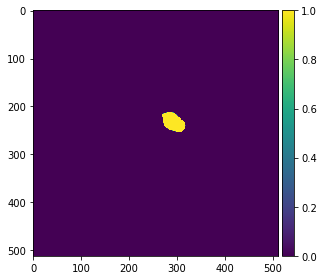

In [44]:
imshow(test_pred[60,:,:,2])

{'verbose': 1, 'epochs': 1, 'steps': 24}